In [9]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


In [16]:
!pip install Pillow

In [167]:
import cv2 as cv2
import pandas as pd
import numpy as np
from collections import defaultdict
# from scipy.stats import itemfreq
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage import feature
from PIL import Image as IMG
import operator
import os
import argparse
from IPython.core.display import HTML 
from IPython.display import Image

# images_path = 'very_good_images [Accuracy _ 95]/'
images_path="Good_Images [85 _ Accuracy _ 95]/"
imgs = os.listdir(images_path)
print(imgs)
features = pd.DataFrame()
features['image'] = imgs
features['Type']=0
print(features['image'])

['0000137486_std.jpg', '2084024865_std.jpg', 'image._std.jpg', 'maxresdefault._std.jpg', 'PMI-471827-1_std.jpg', 'PMI-472031-3_std.jpg', 'PMI-472131-1_std.jpg', 'PMI-472353-2_std.jpg', 'PMI-473789-1_dot__std.jpg', 'PMI-474722-1_std.jpg', 'PMI-475064-1_dot__std.jpg', 'PMI-475376-1_std.jpg', 'PMI-476346-1_std.jpg']
0            0000137486_std.jpg
1            2084024865_std.jpg
2                image._std.jpg
3        maxresdefault._std.jpg
4          PMI-471827-1_std.jpg
5          PMI-472031-3_std.jpg
6          PMI-472131-1_std.jpg
7          PMI-472353-2_std.jpg
8     PMI-473789-1_dot__std.jpg
9          PMI-474722-1_std.jpg
10    PMI-475064-1_dot__std.jpg
11         PMI-475376-1_std.jpg
12         PMI-476346-1_std.jpg
Name: image, dtype: object


In [79]:

def color_analysis(img):
    # obtain the color palatte of the image 
    palatte = defaultdict(int)
    for pixel in img.getdata():
        palatte[pixel] += 1
    
    # sort the colors present in the image 
    sorted_x = sorted(palatte.items(), key=operator.itemgetter(1), reverse = True)
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 0, 25
    for i, x in enumerate(sorted_x[:pixel_limit]):
        if all(xx <= 20 for xx in x[0][:3]): ## dull : too much darkness 
            dark_shade += x[1]
        if all(xx >= 240 for xx in x[0][:3]): ## bright : too much whiteness 
            light_shade += x[1]
        shade_count += x[1]
        
    light_percent = round((float(light_shade)/shade_count)*100, 2)
    dark_percent = round((float(dark_shade)/shade_count)*100, 2)
    return light_percent, dark_percent

In [80]:
def perform_color_analysis(img, flag):
    path = images_path + img 
    im = IMG.open(path) #.convert("RGB")
    
    # cut the images into two halves as complete average may give bias results
    size = im.size
    halves = (size[0]/2, size[1]/2)
    im1 = im.crop((0, 0, size[0], halves[1]))
    im2 = im.crop((0, halves[1], size[0], size[1]))

    try:
        light_percent1, dark_percent1 = color_analysis(im1)
        light_percent2, dark_percent2 = color_analysis(im2)
    except Exception as e:
        return None

    light_percent = (light_percent1 + light_percent2)/2 
    dark_percent = (dark_percent1 + dark_percent2)/2 
    
    if flag == 'black':
        return dark_percent
    elif flag == 'white':
        return light_percent
    else:
        return None

In [83]:
features['dullness'] = features['image'].apply(lambda x : perform_color_analysis(x, 'black'))
features = features.sort_values('dullness', ascending = False)
features.head(5)

,image,Type,dullness
23,Tax-Invoice-GST._std.jpg,0,8.575
6,Book3._std.jpg,0,5.000
7,fomat-of-gst-tax-invoice._std.jpg,0,4.625
0,003-Sales-Order-2-Deposit-SST_1._std.jpg,0,2.810
1,1cf8f4113cd67d2f7e75b9985c1970d5._std.jpg,0,2.255


C:\Users\Charmi Tank\AppData\Local\Temp\ipykernel_9636\2272571715.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))


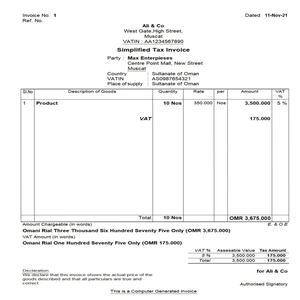

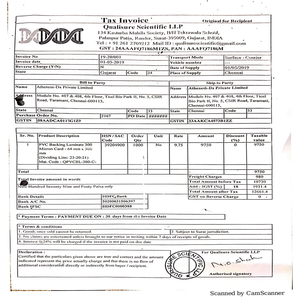

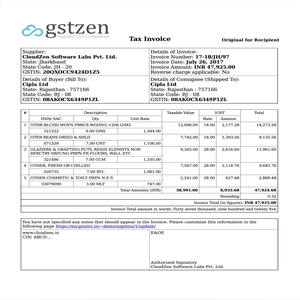

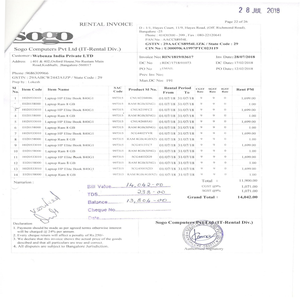

In [87]:
for j,x in features.head(4).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Dullness : " + str(x['dullness']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

In [85]:
features['whiteness'] = features['image'].apply(lambda x : perform_color_analysis(x, 'white'))
features = features.sort_values('whiteness', ascending = False)
features.head(5)

,image,Type,dullness,whiteness
19,simplified-tax-invoice-2._std.jpg,0,0.000,100.000
17,Sales_Invoice__19-20-001_std.jpg,0,0.000,100.000
13,invoice-sample-copy._std.jpg,0,0.000,99.285
3,55_Sogo_std.jpg,0,0.000,99.145
15,New_Bill._std.jpg,0,0.105,99.085


C:\Users\Charmi Tank\AppData\Local\Temp\ipykernel_9636\2076539165.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))


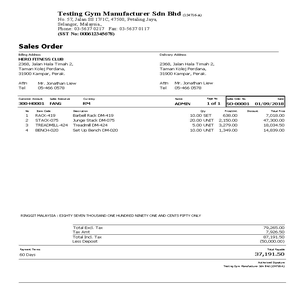

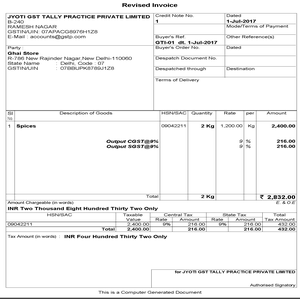

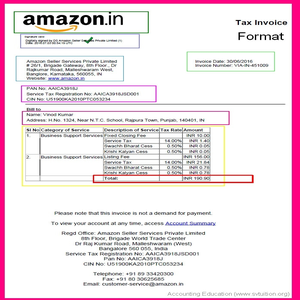

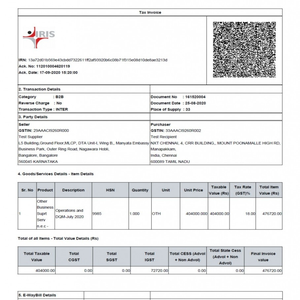

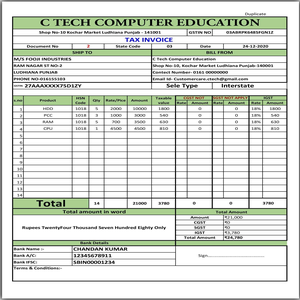

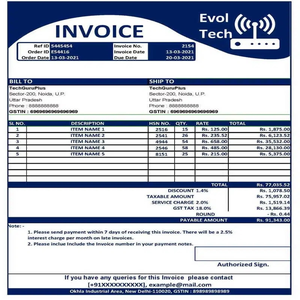

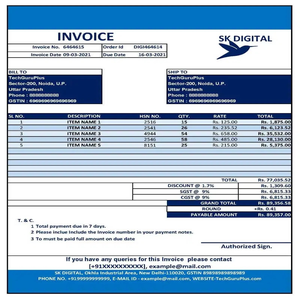

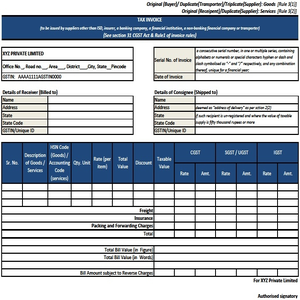

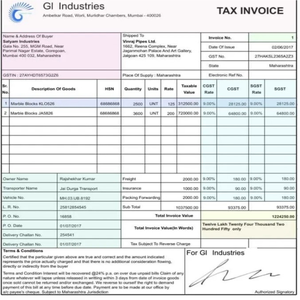

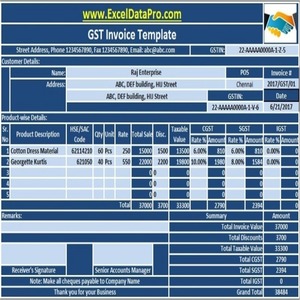

In [88]:
for j,x in features.tail(10).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Whiteness : " + str(x['whiteness']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

In [104]:
# EDA
def noise(img):
    path = images_path + img 
    im1 = IMG.open(path)
    im2 = im1.convert(mode='L')
    im = np.asarray(im2)

    edges1 = feature.canny(im, sigma=1)
    edges2 = feature.canny(im, sigma=3)

    # display results
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True)

    ax1.imshow(im, cmap=plt.cm.gray)
    ax1.axis('off')
    ax1.set_title('noisy image', fontsize=20)

    ax2.imshow(edges1, cmap=plt.cm.gray)
    ax2.axis('off')
    ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

    ax3.imshow(edges2, cmap=plt.cm.gray)
    ax3.axis('off')
    ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

    fig.tight_layout()

    plt.show()

In [114]:
def noisef(img):
    path = images_path + img 
    print(path)
#     image = IMG.open(path)
    image=cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate histogram of saturation channel
    s = cv2.calcHist([image], [1], None, [256], [0, 256])

    # Calculate percentage of pixels with saturation >= p
    p = 0.05
    s_perc = np.sum(s[int(p * 255):-1]) / np.prod(image.shape[0:2])

    ##### Just for visualization and debug; remove in final
#     plt.plot(s)
#     plt.plot([p * 255, p * 255], [0, np.max(s)], 'r')
#     plt.text(p * 255 + 5, 0.9 * np.max(s), str(s_perc))
#     plt.show()
    ##### Just for visualization and debug; remove in final

    # Percentage threshold; above: valid image, below: noise
#     s_thr = 0.5
    return s_perc

In [89]:
def average_pixel_width(img):
    path = images_path + img 
    im = IMG.open(path)    
    im_array = np.asarray(im.convert(mode='L'))
    edges_sigma1 = feature.canny(im_array, sigma=3)
    apw = (float(np.sum(edges_sigma1)) / (im.size[0]*im.size[1]))
    return apw*100

In [103]:
images_path

'very_good_images [Accuracy _ 95]/'

In [90]:
features['average_pixel_width'] = features['image'].apply(average_pixel_width)
features = features.sort_values('average_pixel_width' , ascending = False)
features

,image,Type,dullness,whiteness,average_pixel_width
23,Tax-Invoice-GST._std.jpg,0,8.575,74.935,10.234939
9,GST-Invoice-1._std.jpg,0,0.000,0.000,9.080870
11,gst-tax-invoice._std.jpg,0,0.000,73.580,8.736568
1,1cf8f4113cd67d2f7e75b9985c1970d5._std.jpg,0,2.255,97.590,7.218263
5,Awesome-Template-of-GST-Invoice-Format-in-Exce...,0,0.000,77.015,6.177514
16,Perfect-Design-of-GST-Invoice-Format-in-Excel-...,0,0.270,86.560,6.057022
10,GST-invoice-sample._std.jpg,0,2.065,97.935,5.942514
6,Book3._std.jpg,0,5.000,88.705,5.856644
24,tax-invoice._std.jpg,0,0.000,97.740,5.826680
17,Sales_Invoice__19-20-001_std.jpg,0,0.000,100.000,5.369507


C:\Users\Charmi Tank\AppData\Local\Temp\ipykernel_9636\3110748632.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))


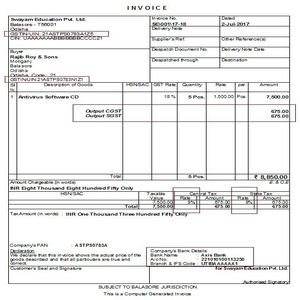

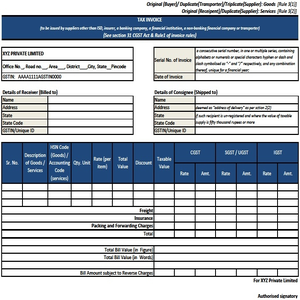

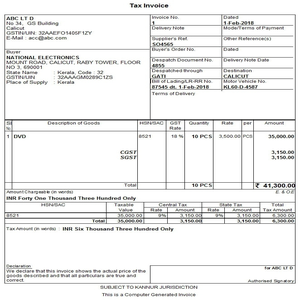

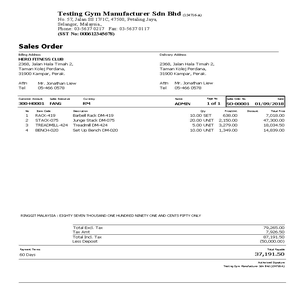

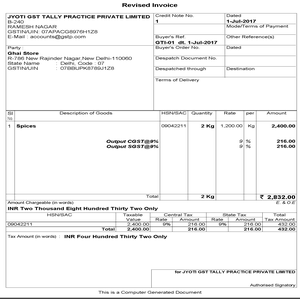

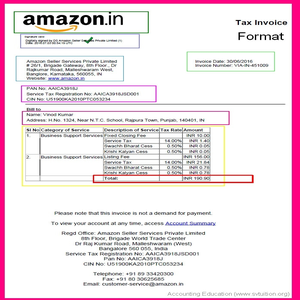

In [91]:
for j,x in tempdf.head(6).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Average Pixel Width : " + str(x['average_pixel_width']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))


In [92]:

def getSize(filename):
    filename = images_path + filename
    st = os.stat(filename)
    return st.st_size

def getDimensions(filename):
    filename = images_path + filename
    img_size = IMG.open(filename).size
    return img_size 

In [168]:
features['image_size'] = features['image'].apply(getSize)
features['temp_size'] = features['image'].apply(getDimensions)
features['width'] = features['temp_size'].apply(lambda x : x[0])
features['height'] = features['temp_size'].apply(lambda x : x[1])
features['noise']=features['image'].apply(lambda x: noisef(x))
# features = features.drop(['temp_size', 'average_color', 'dominant_color'], axis=1)
features

Good_Images [85 _ Accuracy _ 95]/0000137486_std.jpg
Good_Images [85 _ Accuracy _ 95]/2084024865_std.jpg
Good_Images [85 _ Accuracy _ 95]/image._std.jpg
Good_Images [85 _ Accuracy _ 95]/maxresdefault._std.jpg
Good_Images [85 _ Accuracy _ 95]/PMI-471827-1_std.jpg
Good_Images [85 _ Accuracy _ 95]/PMI-472031-3_std.jpg
Good_Images [85 _ Accuracy _ 95]/PMI-472131-1_std.jpg
Good_Images [85 _ Accuracy _ 95]/PMI-472353-2_std.jpg
Good_Images [85 _ Accuracy _ 95]/PMI-473789-1_dot__std.jpg
Good_Images [85 _ Accuracy _ 95]/PMI-474722-1_std.jpg
Good_Images [85 _ Accuracy _ 95]/PMI-475064-1_dot__std.jpg
Good_Images [85 _ Accuracy _ 95]/PMI-475376-1_std.jpg
Good_Images [85 _ Accuracy _ 95]/PMI-476346-1_std.jpg


,image,Type,image_size,temp_size,width,height,noise
0,0000137486_std.jpg,0,117541,"(763, 1001)",763,1001,0.000000
1,2084024865_std.jpg,0,458840,"(759, 1004)",759,1004,0.000000
2,image._std.jpg,0,74630,"(626, 417)",626,417,0.017013
3,maxresdefault._std.jpg,0,193474,"(1280, 720)",1280,720,0.105382
4,PMI-471827-1_std.jpg,0,590468,"(1657, 2332)",1657,2332,0.000000
5,PMI-472031-3_std.jpg,0,1421462,"(1647, 2350)",1647,2350,0.000000
6,PMI-472131-1_std.jpg,0,1084018,"(1683, 2342)",1683,2342,0.000000
7,PMI-472353-2_std.jpg,0,1090434,"(1642, 2330)",1642,2330,0.000000
8,PMI-473789-1_dot__std.jpg,0,1168825,"(2245, 2484)",2245,2484,0.000000
9,PMI-474722-1_std.jpg,0,1703583,"(1657, 2344)",1657,2344,0.000000


In [93]:
def get_blurrness_score(image):
    path =  images_path + image 
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(image, cv2.CV_64F).var()
    return fm

In [95]:
features['blurrness'] = features['image'].apply(get_blurrness_score)
features[['image','blurrness']].sort_values('blurrness', ascending = False).head(40)
features


,image,Type,dullness,whiteness,average_pixel_width,blurrness
23,Tax-Invoice-GST._std.jpg,0,8.575,74.935,10.234939,19925.305865
9,GST-Invoice-1._std.jpg,0,0.000,0.000,9.080870,2821.768796
11,gst-tax-invoice._std.jpg,0,0.000,73.580,8.736568,1505.769830
1,1cf8f4113cd67d2f7e75b9985c1970d5._std.jpg,0,2.255,97.590,7.218263,22239.298024
5,Awesome-Template-of-GST-Invoice-Format-in-Exce...,0,0.000,77.015,6.177514,5841.581595
16,Perfect-Design-of-GST-Invoice-Format-in-Excel-...,0,0.270,86.560,6.057022,3783.248259
10,GST-invoice-sample._std.jpg,0,2.065,97.935,5.942514,17859.824573
6,Book3._std.jpg,0,5.000,88.705,5.856644,3915.315260
24,tax-invoice._std.jpg,0,0.000,97.740,5.826680,6889.850833
17,Sales_Invoice__19-20-001_std.jpg,0,0.000,100.000,5.369507,1549.365037


C:\Users\Charmi Tank\AppData\Local\Temp\ipykernel_9636\1571125150.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))


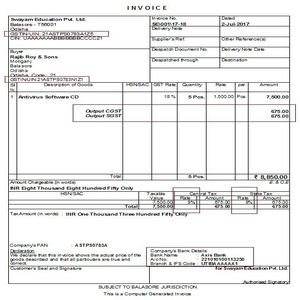

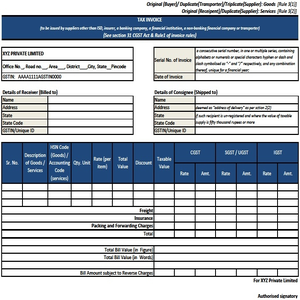

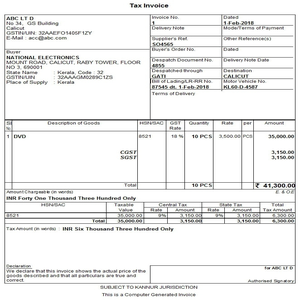

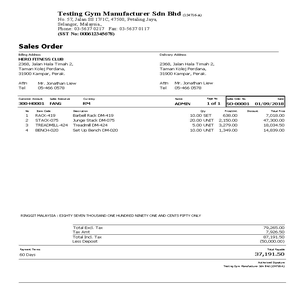

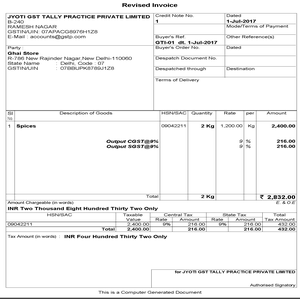

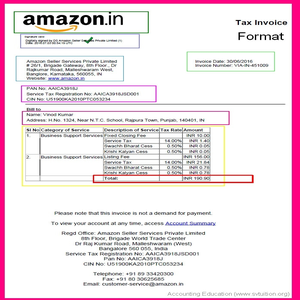

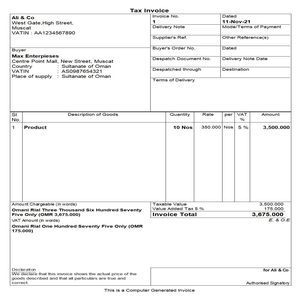

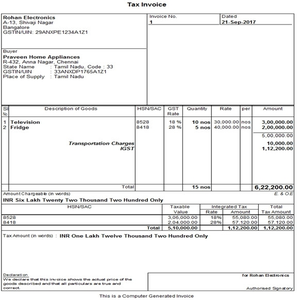

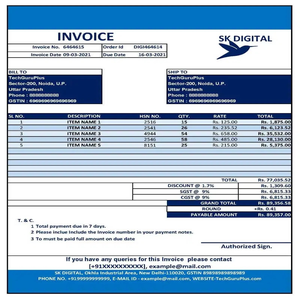

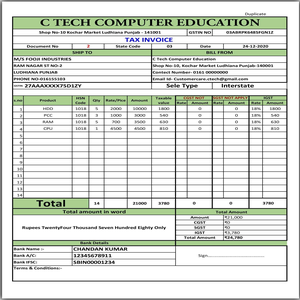

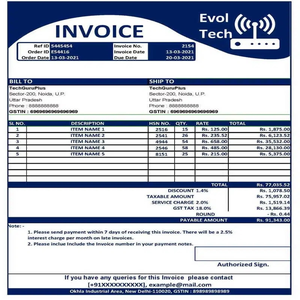

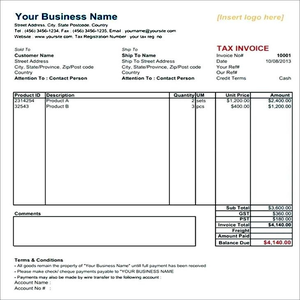

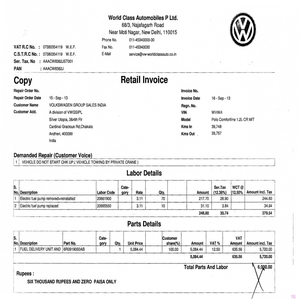

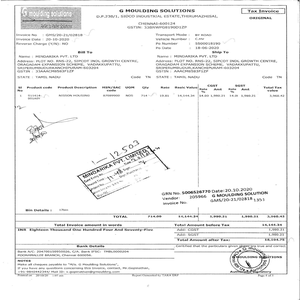

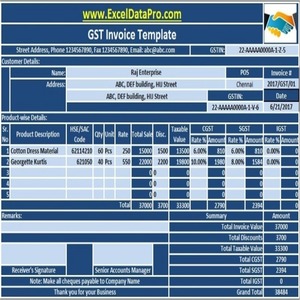

In [97]:
features = features.sort_values('blurrness', ascending = False)
for y,x in tempdf.head(15).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Blurrness : " + str(x['blurrness']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

                                        image  Type  dullness  whiteness  \
1   1cf8f4113cd67d2f7e75b9985c1970d5._std.jpg     0     2.255     97.590   
23                   Tax-Invoice-GST._std.jpg     0     8.575     74.935   
10                GST-invoice-sample._std.jpg     0     2.065     97.935   
0    003-Sales-Order-2-Deposit-SST_1._std.jpg     0     2.810     97.190   
7           fomat-of-gst-tax-invoice._std.jpg     0     4.625     95.375   

    average_pixel_width     blurrness  
1              7.218263  22239.298024  
23            10.234939  19925.305865  
10             5.942514  17859.824573  
0              2.996300  13421.053933  
7              3.815624   9715.877866  


In [189]:
finaldataset = pd.DataFrame(features.filter(['image','dullness','whiteness', 'average_pixel_width' , 'blurrness'], axis=1))
#print(avito_dataset.head())


def perform_features_scoring(avito_dataset):
    for column in avito_dataset:
        if(column == 'dullness'):
            for index, item in avito_dataset.iterrows():
                if(avito_dataset.at[index, "dullness"] <= np.mean(avito_dataset['dullness'])):
                       avito_dataset.at[index , 'dullness_score'] =  1
                else:
                    avito_dataset.at[index , 'dullness_score'] =  0
        elif(column == 'whiteness'):
            for index, item in avito_dataset.iterrows():
                if(avito_dataset.at[index, "whiteness"] <= np.mean(avito_dataset['whiteness'])):
                       avito_dataset.at[index , 'whiteness_score'] =  1
                else:
                    avito_dataset.at[index , 'whiteness_score'] =  0 
        elif(column == 'average_pixel_width'):
            for index, item in avito_dataset.iterrows():
                if(avito_dataset.at[index, "average_pixel_width"] <= np.mean(avito_dataset['average_pixel_width'])):
                       avito_dataset.at[index , 'average_pixel_width_score'] =  1
                else:
                    avito_dataset.at[index , 'average_pixel_width_score'] =  0 
        elif(column == 'blurrness'):
            for index, item in avito_dataset.iterrows():
                if(avito_dataset.at[index, "blurrness"] <= np.mean(avito_dataset['blurrness'])):
                       avito_dataset.at[index , 'blurrness_score'] =  1
                else:
                    avito_dataset.at[index , 'blurrness_score'] =  0 
    return avito_dataset

#print(avito_dataset.head())
    
df = perform_features_scoring(avito_dataset)
df

,image,dullness,whiteness,average_pixel_width,blurrness,dullness_score,whiteness_score,average_pixel_width_score,blurrness_score,skewed_angle
1,1cf8f4113cd67d2f7e75b9985c1970d5._std.jpg,2.255,97.590,7.218263,22239.298024,0.0,0.0,0.0,0.0,0.0
23,Tax-Invoice-GST._std.jpg,8.575,74.935,10.234939,19925.305865,0.0,1.0,0.0,0.0,NaN
10,GST-invoice-sample._std.jpg,2.065,97.935,5.942514,17859.824573,0.0,0.0,0.0,0.0,1.0
0,003-Sales-Order-2-Deposit-SST_1._std.jpg,2.810,97.190,2.996300,13421.053933,0.0,0.0,1.0,0.0,1.0
7,fomat-of-gst-tax-invoice._std.jpg,4.625,95.375,3.815624,9715.877866,0.0,0.0,1.0,0.0,1.0
18,service_tax_invoice_format._std.jpg,0.685,93.210,4.698406,8854.324462,1.0,0.0,1.0,0.0,NaN
21,tax-invoice-format-2-tallyprime._std.jpg,1.410,98.590,3.290169,7543.602275,0.0,0.0,1.0,0.0,NaN
24,tax-invoice._std.jpg,0.000,97.740,5.826680,6889.850833,1.0,0.0,0.0,0.0,NaN
5,Awesome-Template-of-GST-Invoice-Format-in-Exce...,0.000,77.015,6.177514,5841.581595,1.0,1.0,0.0,1.0,1.0
6,Book3._std.jpg,5.000,88.705,5.856644,3915.315260,0.0,1.0,0.0,1.0,1.0


In [190]:
features

,image,Type,image_size,temp_size,width,height,noise,skewed_angle
0,0000137486_std.jpg,0,117541,"(763, 1001)",763,1001,0.000000,-0.203176
1,2084024865_std.jpg,0,458840,"(759, 1004)",759,1004,0.000000,-90.000000
2,image._std.jpg,0,74630,"(626, 417)",626,417,0.017013,-90.000000
3,maxresdefault._std.jpg,0,193474,"(1280, 720)",1280,720,0.105382,-90.000000
4,PMI-471827-1_std.jpg,0,590468,"(1657, 2332)",1657,2332,0.000000,-0.115283
5,PMI-472031-3_std.jpg,0,1421462,"(1647, 2350)",1647,2350,0.000000,-89.009605
6,PMI-472131-1_std.jpg,0,1084018,"(1683, 2342)",1683,2342,0.000000,-89.454346
7,PMI-472353-2_std.jpg,0,1090434,"(1642, 2330)",1642,2330,0.000000,-0.030558
8,PMI-473789-1_dot__std.jpg,0,1168825,"(2245, 2484)",2245,2484,0.000000,-90.000000
9,PMI-474722-1_std.jpg,0,1703583,"(1657, 2344)",1657,2344,0.000000,-89.311104


In [ ]:

# load the image from disk


In [191]:
# convert the image to grayscale and flip the foreground
def skew(img):
    path = images_path +img
#     print(i)
#     image = 
    image = cv2.imread(path)
    # and background to ensure foreground is now "white" and
    # the background is "black"
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)
        skewed="hii"
      
    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle
        return angle
#         if abs(angle)==90 or 0:
#             return 0
#         else:
#             return 1
       
    return angle,skewed

In [192]:
features['skewed_angle']=features['image'].apply(lambda x : skew(x))
# features['skewed']=features['image'].apply(lambda x : skew(x))
# features['blurrness'] = features['image'].apply(get_blurrness_score)
# features[['image','blurrness']].sort_values('blurrness', ascending = False).head(40)
features


,image,Type,image_size,temp_size,width,height,noise,skewed_angle
0,0000137486_std.jpg,0,117541,"(763, 1001)",763,1001,0.000000,-0.203176
1,2084024865_std.jpg,0,458840,"(759, 1004)",759,1004,0.000000,-90.000000
2,image._std.jpg,0,74630,"(626, 417)",626,417,0.017013,-90.000000
3,maxresdefault._std.jpg,0,193474,"(1280, 720)",1280,720,0.105382,-90.000000
4,PMI-471827-1_std.jpg,0,590468,"(1657, 2332)",1657,2332,0.000000,-0.115283
5,PMI-472031-3_std.jpg,0,1421462,"(1647, 2350)",1647,2350,0.000000,-89.009605
6,PMI-472131-1_std.jpg,0,1084018,"(1683, 2342)",1683,2342,0.000000,-89.454346
7,PMI-472353-2_std.jpg,0,1090434,"(1642, 2330)",1642,2330,0.000000,-0.030558
8,PMI-473789-1_dot__std.jpg,0,1168825,"(2245, 2484)",2245,2484,0.000000,-90.000000
9,PMI-474722-1_std.jpg,0,1703583,"(1657, 2344)",1657,2344,0.000000,-89.311104


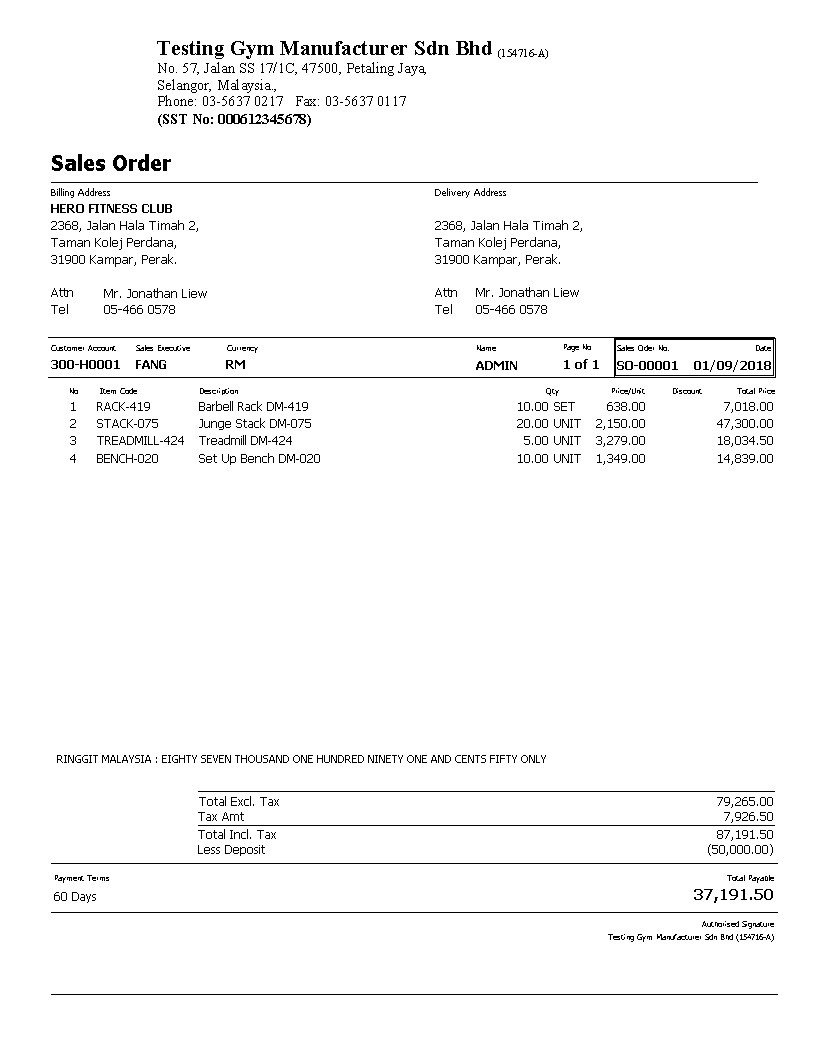

In [187]:
import numpy as np
import math
import cv2

def compute_skew(img):
    
    path = images_path + img 
#     img = IMG.open(path)
    print(path)
    
    height, width = IMG.open(path).size
    src = cv2.imread(path)
    #invert the colors of our image:
    cv2.bitwise_not(src, src)
    
    #Hough transform:
    minLineLength = width/2.0
    maxLineGap = 20
    lines = cv2.HoughLinesP(src,1,np.pi/180,100,minLineLength,maxLineGap)
    
    #calculate the angle between each line and the horizontal line:
    angle = 0.0
    nb_lines = len(lines)
    
    
    for line in lines:
        angle += math.atan2(line[0][3]*1.0 - line[0][1]*1.0,line[0][2]*1.0 - line[0][0]*1.0);
    
    angle /= nb_lines*1.0
    
    return angle* 180.0 / np.pi



  

# file_path = images_path +img
features['skew2']=features['image'].apply(lambda x:compute_skew(x))
features

Good_Images [85 _ Accuracy _ 95]/0000137486_std.jpg


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\hough.cpp:473: error: (-215:Assertion failed) image.type() == CV_8UC1 in function 'cv::HoughLinesProbabilistic'


In [188]:
# path = images_path + img 
# #     img = IMG.open(path)
#     print(path)
    
height, width = IMG.open(path).size
src = cv2.imread("Good_Images [85 _ Accuracy _ 95]/0000137486_std.jpg")
    #invert the colors of our image:
cv2.bitwise_not(src, src)
    
    #Hough transform:
minLineLength = width/2.0
maxLineGap = 20
lines = cv2.HoughLinesP(src,1,np.pi/180,100,minLineLength,maxLineGap)
    
    #calculate the angle between each line and the horizontal line:
angle = 0.0
nb_lines = len(lines)
    
    
for line in lines:
        angle += math.atan2(line[0][3]*1.0 - line[0][1]*1.0,line[0][2]*1.0 - line[0][0]*1.0);
    
angle /= nb_lines*1.0
    
angle* 180.0 / np.pi

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\hough.cpp:473: error: (-215:Assertion failed) image.type() == CV_8UC1 in function 'cv::HoughLinesProbabilistic'


In [ ]:
def pixel_brightness(pixel):
    assert 3 == len(pixel)
    r, g, b = pixel
    return math.sqrt(0.299 * r ** 2 + 0.587 * g ** 2 + 0.114 * b ** 2)
def image_brightness(img):
    nr_of_pixels = len(img) * len(img[0])
    return sum(pixel_brightness(pixel) for pixel in row for row in img) / nr_of_pixels